In [1]:
# ==============================================================================
# Task 1: Enhanced Object Detection using Classical Computer Vision
# Multi-Feature Matching (ORB + SIFT) + Improved Segmentation
# Jupyter Notebook Implementation
# ==============================================================================

# Cell 1: Install and Import Dependencies
# ==============================================================================
"""
Run this cell first to install required packages (if not already installed)
Uncomment the line below if needed:
"""
# !pip install opencv-python opencv-contrib-python numpy pillow matplotlib scikit-image

import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import defaultdict
import os
from pathlib import Path

# Set matplotlib to display images inline
%matplotlib inline

print("✅ Dependencies loaded successfully!")

✅ Dependencies loaded successfully!


In [2]:
# Cell 2: Enhanced Object Detector with Multiple Features
# ==============================================================================
class EnhancedObjectDetector:
    """
    Enhanced classical CV detector with:
    - Multiple feature descriptors (ORB + SIFT)
    - Improved segmentation with multiple methods
    - Scale normalization
    - Ensemble matching
    """
    
    def __init__(self, use_sift=True):
        """
        Initialize the detector with multiple feature extractors.
        
        Args:
            use_sift: Whether to use SIFT in addition to ORB (slower but more accurate)
        """
        self.orb = cv2.ORB_create(nfeatures=2000)
        self.use_sift = use_sift
        
        if use_sift:
            try:
                self.sift = cv2.SIFT_create(nfeatures=1000)
                print("✅ Using ORB + SIFT features")
            except:
                print("⚠️ SIFT not available, using only ORB")
                self.use_sift = False
        else:
            print("✅ Using ORB features only")
        
        self.matcher_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        if self.use_sift:
            self.matcher_sift = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        
        self.templates = {}  # {object_name: [template1, template2, ...]}
        print("EnhancedObjectDetector initialized")
    
    def preprocess_image(self, image):
        """Enhanced preprocessing with multiple techniques."""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply bilateral filter
        denoised = cv2.bilateralFilter(gray, 9, 75, 75)
        
        # Enhance contrast using CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(denoised)
        
        return enhanced
    
    def segment_objects_multi_method(self, image, min_area=1000):
        """
        Enhanced segmentation using multiple methods and merging results.
        
        Args:
            image: BGR image
            min_area: Minimum contour area
            
        Returns:
            List of bounding boxes
        """
        gray = self.preprocess_image(image)
        all_bboxes = []
        
        # Method 1: Canny edges + morphology
        edges = cv2.Canny(gray, 30, 100)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=3)
        dilated = cv2.dilate(closed, kernel, iterations=2)
        
        contours1, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours1:
            if cv2.contourArea(contour) > min_area:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = w / float(h) if h > 0 else 0
                if 0.1 < aspect_ratio < 10:
                    all_bboxes.append((x, y, w, h))
        
        # Method 2: Adaptive thresholding
        adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)
        kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        morphed = cv2.morphologyEx(adaptive, cv2.MORPH_CLOSE, kernel2, iterations=2)
        
        contours2, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours2:
            if cv2.contourArea(contour) > min_area:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = w / float(h) if h > 0 else 0
                if 0.1 < aspect_ratio < 10:
                    all_bboxes.append((x, y, w, h))
        
        # Method 3: Otsu's thresholding
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        morphed2 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        contours3, _ = cv2.findContours(morphed2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours3:
            if cv2.contourArea(contour) > min_area:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = w / float(h) if h > 0 else 0
                if 0.1 < aspect_ratio < 10:
                    all_bboxes.append((x, y, w, h))
        
        # Merge and remove duplicates
        bboxes = self._non_max_suppression(all_bboxes, overlap_thresh=0.4)
        
        print(f"📦 Found {len(bboxes)} object candidates (merged from {len(all_bboxes)} raw detections)")
        return bboxes
    
    def _non_max_suppression(self, boxes, overlap_thresh=0.5):
        """Apply NMS with improved IoU calculation."""
        if len(boxes) == 0:
            return []
        
        boxes = np.array(boxes)
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 0] + boxes[:, 2]
        y2 = boxes[:, 1] + boxes[:, 3]
        areas = boxes[:, 2] * boxes[:, 3]
        
        indices = np.argsort(areas)[::-1]
        keep = []
        
        while len(indices) > 0:
            i = indices[0]
            keep.append(i)
            
            if len(indices) == 1:
                break
            
            xx1 = np.maximum(x1[i], x1[indices[1:]])
            yy1 = np.maximum(y1[i], y1[indices[1:]])
            xx2 = np.minimum(x2[i], x2[indices[1:]])
            yy2 = np.minimum(y2[i], y2[indices[1:]])
            
            w = np.maximum(0, xx2 - xx1)
            h = np.maximum(0, yy2 - yy1)
            
            intersection = w * h
            union = areas[i] + areas[indices[1:]] - intersection
            iou = intersection / union
            
            indices = indices[1:][iou <= overlap_thresh]
        
        return boxes[keep].tolist()
    
    def normalize_template_size(self, image, target_size=256):
        """Resize template to standard size while preserving aspect ratio."""
        h, w = image.shape[:2]
        if max(h, w) > target_size:
            scale = target_size / max(h, w)
            new_w = int(w * scale)
            new_h = int(h * scale)
            return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        return image
    
    def extract_features(self, gray_image):
        """Extract both ORB and SIFT features."""
        features = {}
        
        # ORB features
        kp_orb, desc_orb = self.orb.detectAndCompute(gray_image, None)
        features['orb'] = {'keypoints': kp_orb, 'descriptors': desc_orb}
        
        # SIFT features (if enabled)
        if self.use_sift:
            kp_sift, desc_sift = self.sift.detectAndCompute(gray_image, None)
            features['sift'] = {'keypoints': kp_sift, 'descriptors': desc_sift}
        
        return features
    
    def match_with_ransac(self, desc_template, desc_roi, kp_template, kp_roi, 
                         feature_type='orb', min_matches=10):
        """Match features with RANSAC verification."""
        if desc_template is None or desc_roi is None:
            return 0, 0.0
        
        if len(kp_template) < min_matches or len(kp_roi) < min_matches:
            return 0, 0.0
        
        # Choose appropriate matcher
        matcher = self.matcher_orb if feature_type == 'orb' else self.matcher_sift
        
        # Match with KNN
        try:
            matches = matcher.knnMatch(desc_template, desc_roi, k=2)
        except:
            return 0, 0.0
        
        # Lowe's ratio test
        ratio_thresh = 0.75 if feature_type == 'orb' else 0.7
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < ratio_thresh * n.distance:
                    good_matches.append(m)
        
        if len(good_matches) < min_matches:
            return 0, 0.0
        
        # RANSAC
        src_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_roi[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        if len(good_matches) >= 4:
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            inliers = mask.sum() if mask is not None else 0
            confidence = inliers / len(good_matches) if len(good_matches) > 0 else 0
            return int(inliers), float(confidence)
        
        return 0, 0.0
    
    def match_template_ensemble(self, roi_gray, template_data, min_matches=10):
        """
        Match using ensemble of ORB and SIFT features.
        Returns weighted average confidence.
        """
        roi_features = self.extract_features(roi_gray)
        
        # ORB matching
        orb_inliers, orb_conf = self.match_with_ransac(
            template_data['features']['orb']['descriptors'],
            roi_features['orb']['descriptors'],
            template_data['features']['orb']['keypoints'],
            roi_features['orb']['keypoints'],
            'orb',
            min_matches
        )
        
        # SIFT matching (if available)
        if self.use_sift and 'sift' in template_data['features']:
            sift_inliers, sift_conf = self.match_with_ransac(
                template_data['features']['sift']['descriptors'],
                roi_features['sift']['descriptors'],
                template_data['features']['sift']['keypoints'],
                roi_features['sift']['keypoints'],
                'sift',
                min_matches
            )
            
            # Weighted ensemble (SIFT is more reliable, so higher weight)
            total_inliers = orb_inliers + sift_inliers
            ensemble_conf = (0.4 * orb_conf + 0.6 * sift_conf)
            
            return total_inliers, ensemble_conf
        
        return orb_inliers, orb_conf
    
    def add_template(self, template_path, object_name):
        """Add template with both ORB and SIFT features."""
        template_img = cv2.imread(template_path)
        if template_img is None:
            print(f"❌ Warning: Could not load template {template_path}")
            return
        
        # Normalize size
        template_img = self.normalize_template_size(template_img)
        gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
        
        # Extract all features
        features = self.extract_features(gray)
        
        template_data = {
            'image': template_img,
            'gray': gray,
            'features': features,
            'shape': gray.shape,
            'path': template_path
        }
        
        if object_name not in self.templates:
            self.templates[object_name] = []
        
        self.templates[object_name].append(template_data)
        
        orb_kp = len(features['orb']['keypoints'])
        sift_kp = len(features['sift']['keypoints']) if self.use_sift else 0
        print(f"✅ Added '{object_name}': ORB={orb_kp} kp" + 
              (f", SIFT={sift_kp} kp" if self.use_sift else ""))
    
    def load_templates_from_folder(self, templates_folder="templates"):
        """Load all templates from folder structure."""
        template_path = Path(templates_folder)
        if not template_path.exists():
            print(f"❌ Templates folder not found: {templates_folder}")
            return
        
        print(f"\n🔍 Loading templates from: {templates_folder}")
        print("="*60)
        
        # Load individual files
        for file in template_path.glob("*_template.*"):
            if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                object_name = file.stem.replace('_template', '')
                self.add_template(str(file), object_name)
        
        # Load from subfolders
        for subfolder in template_path.iterdir():
            if subfolder.is_dir() and not subfolder.name.startswith('.'):
                object_name = subfolder.name
                for img_file in subfolder.glob("*.*"):
                    if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.add_template(str(img_file), object_name)
        
        print("="*60)
        print(f"📊 Loaded templates for {len(self.templates)} object types:")
        for obj_name, templates_list in self.templates.items():
            print(f"   • {obj_name}: {len(templates_list)} template(s)")
        print()
    
    def match_object_class(self, roi_gray, object_name, min_matches=8):
        """Match ROI against all templates for an object class."""
        if object_name not in self.templates:
            return 0, 0.0, -1
        
        best_inliers = 0
        best_confidence = 0.0
        best_template_idx = -1
        
        for idx, template_data in enumerate(self.templates[object_name]):
            inliers, confidence = self.match_template_ensemble(roi_gray, template_data, min_matches)
            
            if confidence > best_confidence:
                best_confidence = confidence
                best_inliers = inliers
                best_template_idx = idx
        
        return best_inliers, best_confidence, best_template_idx
    
    def detect_objects(self, image_path, object_list, min_confidence=0.25):
        """Detect objects with enhanced matching."""
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if isinstance(object_list, str) and object_list.lower() == "all":
            object_list = list(self.templates.keys())
        
        active_objects = [obj for obj in object_list if obj in self.templates]
        
        if not active_objects:
            print("⚠️ Warning: No templates loaded for requested objects")
            return Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), {
                'boxes': [], 'scores': [], 'labels': []
            }
        
        print(f"🔍 Searching for: {active_objects}")
        print(f"📝 Total templates: {sum(len(self.templates[obj]) for obj in active_objects)}")
        
        # Enhanced segmentation
        bboxes = self.segment_objects_multi_method(image, min_area=800)
        
        detections = {'boxes': [], 'scores': [], 'labels': [], 'template_used': []}
        
        for bbox_idx, bbox in enumerate(bboxes):
            x, y, w, h = bbox
            roi_gray = gray[y:y+h, x:x+w]
            
            # Skip very small ROIs
            if w < 30 or h < 30:
                continue
            
            best_match = None
            best_confidence = 0
            best_inliers = 0
            best_template_info = None
            
            for obj_name in active_objects:
                inliers, confidence, template_idx = self.match_object_class(
                    roi_gray, obj_name, min_matches=8
                )
                
                if confidence > best_confidence and confidence >= min_confidence:
                    best_confidence = confidence
                    best_match = obj_name
                    best_inliers = inliers
                    best_template_info = f"{obj_name}_t{template_idx}"
            
            if best_match is not None:
                detections['boxes'].append([x, y, x+w, y+h])
                detections['scores'].append(best_confidence)
                detections['labels'].append(best_match)
                detections['template_used'].append(best_template_info)
                print(f"  ✓ [{bbox_idx+1}] {best_match}: conf={best_confidence:.3f}, inliers={best_inliers}")
        
        detections['boxes'] = np.array(detections['boxes']) if detections['boxes'] else np.array([])
        detections['scores'] = np.array(detections['scores']) if detections['scores'] else np.array([])
        
        print(f"\n🎯 Detections: {len(detections['labels'])} objects")
        
        annotated_image = self._draw_boxes(image, detections)
        return annotated_image, detections
    
    def _draw_boxes(self, image, detections):
        """Draw bounding boxes."""
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image_rgb)
        draw = ImageDraw.Draw(pil_image)
        
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
        except:
            font = ImageFont.load_default()
        
        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]
        
        for idx, (box, score, label) in enumerate(zip(detections['boxes'], detections['scores'], detections['labels'])):
            color = colors[idx % len(colors)]
            x1, y1, x2, y2 = box
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
            
            label_text = f"{label}: {score:.2f}"
            bbox = draw.textbbox((x1, y1), label_text, font=font)
            draw.rectangle([x1, y1 - (bbox[3]-bbox[1]) - 4, x1 + (bbox[2]-bbox[0]) + 4, y1], fill=color)
            draw.text((x1 + 2, y1 - (bbox[3]-bbox[1]) - 2), label_text, fill="white", font=font)
        
        return pil_image
    
    def visualize_results(self, original_path, annotated_image):
        """Display results."""
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))
        original = cv2.imread(original_path)
        axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original", fontsize=14, fontweight='bold')
        axes[0].axis('off')
        axes[1].imshow(annotated_image)
        axes[1].set_title("Enhanced Detection", fontsize=14, fontweight='bold')
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()

print("✅ EnhancedObjectDetector class defined!")

✅ EnhancedObjectDetector class defined!


In [3]:
# Cell 3: Initialize Enhanced Detector
# ==============================================================================
# Set use_sift=True for better accuracy (slower) or False for speed
detector = EnhancedObjectDetector(use_sift=True)
detector.load_templates_from_folder("templates")
# Cell 3B: Add Post-Processing NMS Function
# ==============================================================================
def post_process_detections(detections, iou_threshold=0.3):
    """
    Apply Non-Maximum Suppression on final detections to remove duplicates.
    Groups detections by class and applies NMS per class.
    """
    if len(detections['boxes']) == 0:
        return detections
    
    boxes = detections['boxes']
    scores = detections['scores']
    labels = detections['labels']
    
    # Group by label
    unique_labels = list(set(labels))
    keep_indices = []
    
    for label in unique_labels:
        # Get indices for this label
        label_indices = [i for i, l in enumerate(labels) if l == label]
        label_boxes = boxes[label_indices]
        label_scores = scores[label_indices]
        
        # Apply NMS
        keep_label = nms_per_class(label_boxes, label_scores, iou_threshold)
        keep_indices.extend([label_indices[i] for i in keep_label])
    
    # Filter detections
    filtered_detections = {
        'boxes': boxes[keep_indices] if len(keep_indices) > 0 else np.array([]),
        'scores': scores[keep_indices] if len(keep_indices) > 0 else np.array([]),
        'labels': [labels[i] for i in keep_indices],
        'template_used': [detections['template_used'][i] for i in keep_indices] if 'template_used' in detections else []
    }
    
    return filtered_detections

def nms_per_class(boxes, scores, iou_threshold=0.3):
    """NMS for a single class."""
    if len(boxes) == 0:
        return []
    
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1) * (y2 - y1)
    
    # Sort by score (descending)
    order = scores.argsort()[::-1]
    keep = []
    
    while len(order) > 0:
        i = order[0]
        keep.append(i)
        
        if len(order) == 1:
            break
        
        # Compute IoU with remaining boxes
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        
        intersection = w * h
        union = areas[i] + areas[order[1:]] - intersection
        iou = intersection / union
        
        # Keep only boxes with IoU below threshold
        order = order[1:][iou <= iou_threshold]
    
    return keep

print("✅ Post-processing functions defined!")

✅ Using ORB + SIFT features
EnhancedObjectDetector initialized

🔍 Loading templates from: templates
✅ Added 'scissors': ORB=145 kp, SIFT=51 kp
✅ Added 'wrench': ORB=207 kp, SIFT=65 kp
✅ Added 'bottle': ORB=127 kp, SIFT=63 kp
✅ Added 'mug': ORB=302 kp, SIFT=61 kp
✅ Added 'screwdriver': ORB=85 kp, SIFT=42 kp
✅ Added 'mug': ORB=255 kp, SIFT=66 kp
✅ Added 'mug': ORB=311 kp, SIFT=45 kp
✅ Added 'mug': ORB=232 kp, SIFT=64 kp
✅ Added 'mug': ORB=322 kp, SIFT=59 kp
✅ Added 'mug': ORB=265 kp, SIFT=41 kp
✅ Added 'mug': ORB=228 kp, SIFT=65 kp
✅ Added 'mug': ORB=268 kp, SIFT=45 kp
✅ Added 'mug': ORB=302 kp, SIFT=61 kp
✅ Added 'shoes': ORB=174 kp, SIFT=69 kp
✅ Added 'shoes': ORB=186 kp, SIFT=94 kp
✅ Added 'shoes': ORB=218 kp, SIFT=58 kp
✅ Added 'shoes': ORB=217 kp, SIFT=66 kp
✅ Added 'shoes': ORB=177 kp, SIFT=65 kp
✅ Added 'shoes': ORB=125 kp, SIFT=61 kp
✅ Added 'shoes': ORB=209 kp, SIFT=66 kp
✅ Added 'shoes': ORB=190 kp, SIFT=59 kp
✅ Added 'shoes': ORB=190 kp, SIFT=64 kp
✅ Added 'shoes': ORB=186 kp,

In [12]:
# Cell 4: Run Enhanced Detection
# ==============================================================================
image_path = "data/examples/input_1.jpg"
objects_to_detect = ["shoes"]

annotated_img, detections = detector.detect_objects(
    image_path,
    objects_to_detect,
    min_confidence=0.45  # Lower threshold for more detections
)

annotated_img.save("output_task1_enhanced.jpg")
print("\n💾 Saved to 'output_task1_enhanced.jpg'")

🔍 Searching for: ['shoes']
📝 Total templates: 11
📦 Found 109 object candidates (merged from 119 raw detections)
  ✓ [1] shoes: conf=0.600, inliers=14
  ✓ [2] shoes: conf=0.474, inliers=15
  ✓ [4] shoes: conf=0.585, inliers=39
  ✓ [9] shoes: conf=0.600, inliers=9
  ✓ [27] shoes: conf=0.600, inliers=11

🎯 Detections: 5 objects

💾 Saved to 'output_task1_enhanced.jpg'


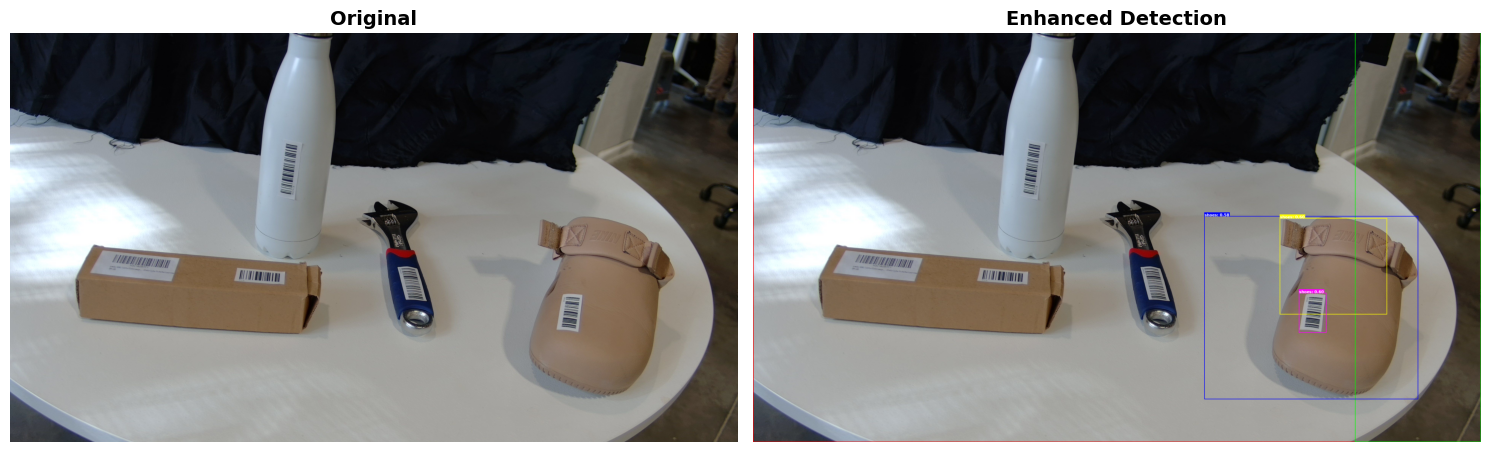

In [13]:
# Cell 5: Visualize Results
# ==============================================================================
detector.visualize_results(image_path, annotated_img)

In [ ]:
# Cell 6: Detailed Results
# ==============================================================================
print("\n" + "="*70)
print("📊 DETECTION RESULTS")
print("="*70)
if len(detections['labels']) > 0:
    for i, (box, score, label) in enumerate(zip(detections['boxes'], detections['scores'], detections['labels'])):
        print(f"{i+1}. {label.upper()}: confidence={score:.3f}, box=[{int(box[0])},{int(box[1])},{int(box[2])},{int(box[3])}]")
else:
    print("No detections. Try: lower min_confidence, add more templates, or check segmentation")
print("="*70)